# Analysis

Create figures and animations from tau_map6 simulation.

## Notebook Configuration

### Imports

In [1]:
# import packages
import os
import warnings
from os import PathLike
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

from matplotlib import colormaps
from matplotlib.ticker import MaxNLocator
from matplotlib.animation import FuncAnimation

from rich import print
from tqdm import tqdm

In [2]:
# import modules
from configurations import DEF_VAR_LIST, DEF_REM_COL_LIST, CSTYLE_FILE_STR
from grouped_bar_plot import grouped_bar_plot
from processing import load_mat_dir
from distributions import plot_clusters, create_protein_animation

In [3]:
# define the data directory
DATA_DIR = Path("data", "paper1_true")

# configure the figure save directory
FIGURE_DIR = Path("figures", DATA_DIR.parts[-1])
os.makedirs(FIGURE_DIR, exist_ok=True)

# configure the animation save directory
ANIMATION_DIR = Path("animations", DATA_DIR.parts[-1])
os.makedirs(ANIMATION_DIR, exist_ok=True)

# set plotting style
plt.style.use(["default", CSTYLE_FILE_STR])

# set the colormap
DEFAULT_COLORMAP = list(colormaps["tab10"].colors)

### Data Import

In [4]:
# get the data dictionary from the data directory
data_dict = load_mat_dir(DATA_DIR, DEF_VAR_LIST, DEF_REM_COL_LIST)

### Add Calculations

In [5]:
# add the final MT length to the sim_df
data_dict["sims"].keys()
length_vals = {}
for sim_name, sim_dict in data_dict["sims"].items():
    # extract the final length as the last entry in first col of mt_length
    length_vals[sim_name] = sim_dict["mt_length"][-1, 0]

# add the dictionary to the df
data_dict["df"]["final_length_units"] = data_dict["df"].index.map(length_vals)

# add final length column
data_dict["df"]["final_length"] = data_dict["df"]["final_length_units"]*data_dict["df"]["dx"]

In [6]:
# create an averages df grouped by tm_ratio
data_avg_df = data_dict["df"].groupby("tm_ratio").mean()

## Define Functions

In [7]:
# define a function to print the sim options
def print_options():
    # print the sim options
    print("Available simulations:\n", "\n ".join([f"{i} {sim_name}" for i, sim_name in enumerate(data_dict["sims"].keys())]))

## Averages DF Plotting

### Binding Rate Ratio vs. MT Length

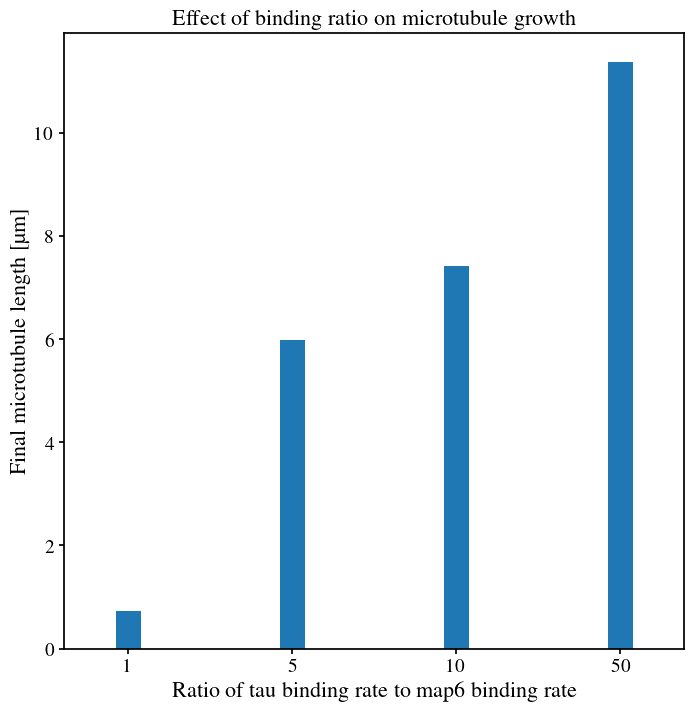

In [8]:
# define the grouped data and group labels
group_data = {"L": data_avg_df["final_length"]}
group_labels = data_avg_df.index

# define the figure
fig, ax = plt.subplots()

# plot the grouped bar plot
fig, ax = grouped_bar_plot(
    fig, ax,
    group_data,
    group_labels,
    multiplier=1,
    colors=DEFAULT_COLORMAP)

# add a margin via xmargin to the x axis
ax.margins(x=0.1)

# set the labels
ax.set_xlabel(r"Ratio of tau binding rate to map6 binding rate")
ax.set_ylabel(r"Final microtubule length [$\qty{}{\micro\meter}$]")
ax.set_title(r"Effect of binding ratio on microtubule growth")

# save the figure
fig.savefig(FIGURE_DIR / r"growth_effect")

### Plot Binding Asymmetry

In [9]:
data_avg_df

,alpha_m,alpha_t,dt,dx,f_cat,f_res,m_off,m_on,map6_frac_length,map6_frac_tip,...,steps,t_force,t_off,t_on,tau_frac_length,tau_frac_tip,tau_plus_end_asym,ttot,final_length_units,final_length
tm_ratio,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.001,0.036,300.0,500.0,0.1,0.1,0.000000,0.0,...,1001.0,1.0,0.1,0.1,0.000000,0.090909,inf,1.0,20.0,0.72
5,0.0,0.0,0.001,0.036,300.0,500.0,0.1,0.1,0.000000,0.0,...,1001.0,1.0,0.5,0.5,0.825806,1.000000,1.210938,1.0,166.0,5.976
10,0.0,0.0,0.001,0.036,300.0,500.0,0.1,0.1,0.010256,0.0,...,1001.0,1.0,1.0,1.0,0.651282,1.000000,1.535433,1.0,206.0,7.416
50,0.0,0.0,0.001,0.036,300.0,500.0,0.1,0.1,0.013115,0.0,...,1001.0,1.0,5.0,5.0,0.514754,0.818182,1.589461,1.0,316.0,11.376


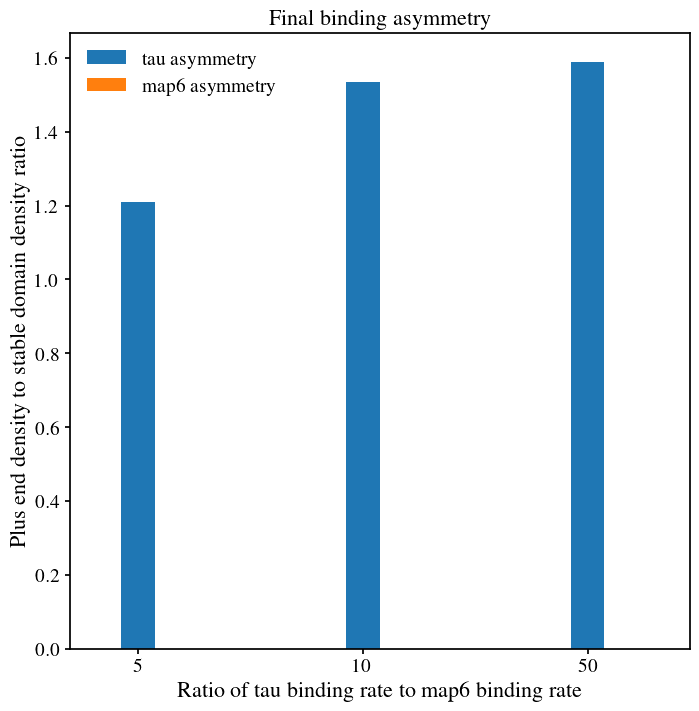

In [10]:
# make a grouped bar plot of binding asymmetry
# on the horizontal: ratio of tau binding rate to map6 binding rate
# on the vertical:
# 1. tau plus end density to stable domain density ratio (tauasymm)
# 2. map6 plus end density to stable domain density ratio (mapasymm)

# define the group data and group labels
group_data = {"tau asymmetry": data_avg_df["tau_plus_end_asym"], "map6 asymmetry": data_avg_df["map6_plus_end_asym"]}
group_labels = data_avg_df.index

# define the figure
fig, ax = plt.subplots()

# plot the data
fig, ax = grouped_bar_plot(
    fig, ax,
    group_data,
    group_labels,
    multiplier=1,
    colors=DEFAULT_COLORMAP)

# add a margin via xmargin to the x axis
ax.margins(x=0.1)

# set the labels
ax.set_xlabel(r"Ratio of tau binding rate to map6 binding rate")
ax.set_ylabel(r"Plus end density to stable domain density ratio")
ax.set_title(r"Final binding asymmetry")

# set the legend
ax.legend(loc="upper left")

# save the figure
fig.savefig(FIGURE_DIR / r"asymm_effect")

### Plot Distribution Dependence on Tau On-Rate

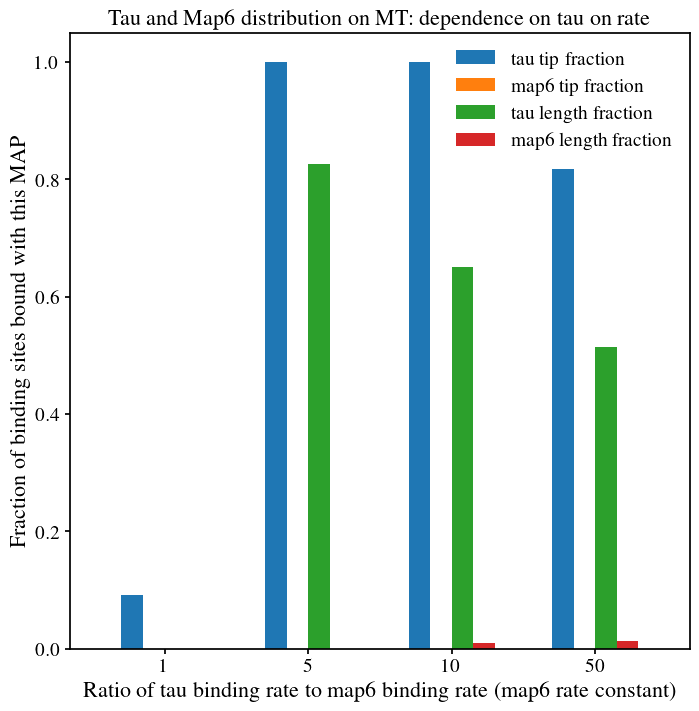

In [11]:
# make a grouped bar plot
# on the horizontal: ratio of tau binding rate to map6 binding rate
# on the vertical:
# 1. plus-end tau fraction (taufractip)
# 2. plus-end map6 fraction (mapfractip)
# 3. stable domain tau fraction (taufraclength)
# 4. stable domain map6 fraction (mapfraclength)

# define the group data and group labels (T0/M0)
group_data = {
    "tau tip fraction": data_avg_df["tau_frac_tip"],
    "map6 tip fraction": data_avg_df["map6_frac_tip"],
    "tau length fraction": data_avg_df["tau_frac_length"],
    "map6 length fraction": data_avg_df["map6_frac_length"],
}
group_labels = data_avg_df.index

# define the figure
fig, ax = plt.subplots()

# plot the data
fig, ax = grouped_bar_plot(
    fig, ax,
    group_data,
    group_labels,
    multiplier=-1/2,
    colors=DEFAULT_COLORMAP)

# add a margin via xmargin to the x axis
ax.margins(x=0.1)

# set the labels
ax.set_xlabel(r"Ratio of tau binding rate to map6 binding rate (map6 rate constant)")
ax.set_ylabel(r"Fraction of binding sites bound with this MAP")
ax.set_title(r"Tau and Map6 distribution on MT: dependence on tau on rate")

# add a legend
ax.legend()

# save the figure
fig.savefig(FIGURE_DIR / r"binding_distribution_grouped")

## Group Sim Plotting

### Plot MT Length over Time

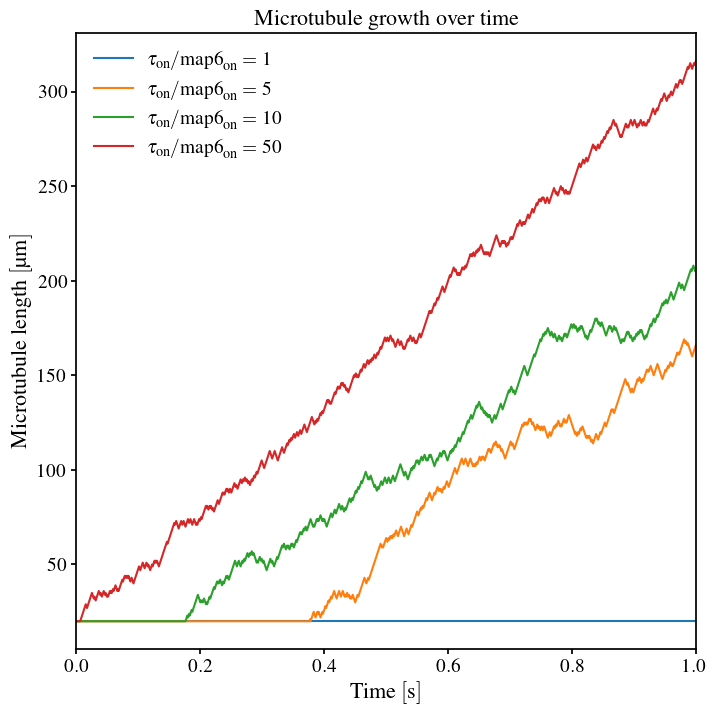

In [12]:
# plot the length of the mt over time
# define the figure
fig, ax = plt.subplots()

# define a dictionary to color similar tau_ratios
tau_ratio_dict = {}

# iterate over each simulation in sim_dict and get the time and length array
sim_names = list(data_dict["sims"].keys())
sim_names.sort(key=lambda x: data_dict["df"].loc[x]["tm_ratio"])
for index, sim_name in enumerate(sim_names):
    # get the arrays
    mt_length_array = data_dict["sims"][sim_name]["mt_length"]
    length_list = mt_length_array[:, 0]

    # get the time information
    dt = data_dict["df"].loc[sim_name]["dt"]
    ttot = data_dict["df"].loc[sim_name]["ttot"]
    time_list = np.arange(0, ttot+dt, dt)

    # get the tau binding rate T0 ratio
    tau_ratio = data_dict["df"].loc[sim_name]["tm_ratio"]

    # define the label
    label = r"$\tau_{\text{on}}/\text{map6}_\text{on}=" + f"{tau_ratio}" + r"\ $"

    # get a unique color for each tau ratio
    # if the color has been used, make the label None
    if tau_ratio not in tau_ratio_dict.keys():
        tau_ratio_dict[tau_ratio] = DEFAULT_COLORMAP[index]
    else:
        label = None

    # plot the length over time for this mt
    ax.plot(
        time_list,
        length_list,
        label=label,
        color=tau_ratio_dict[tau_ratio]
    )

# set the axis limits
# the x limit should be the final time plus the second time
# this has the effect of showing an "even" value
ax.set_xlim(0, time_list[-1] + time_list[1])

# set the labels
ax.set_xlabel(r"Time $\left[\qty{}{\second}\right]$")
ax.set_ylabel(r"Microtubule length $\left[\qty{}{\micro\meter}\right]$")
ax.set_title(r"Microtubule growth over time")

# add a legend
ax.legend()

# save the figure
fig.savefig(FIGURE_DIR / r"mt_growth_over_time")

## Plot Clusters

In [13]:
print_options()

Available simulations:
 0 taumap6_10_true
 1 taumap6_1_true
 2 taumap6_5_true
 3 taumap6_50_true

In [14]:
# define the name of the sim to plot
sim_name = list(data_dict["sims"].keys())[0]
time_step = -1
print(f"Plotting '{sim_name}' / {list(data_dict['sims'].keys())}.")

Plotting 'taumap6_10_true' / ['taumap6_10_true', 'taumap6_1_true', 'taumap6_5_true', 'taumap6_50_true'].

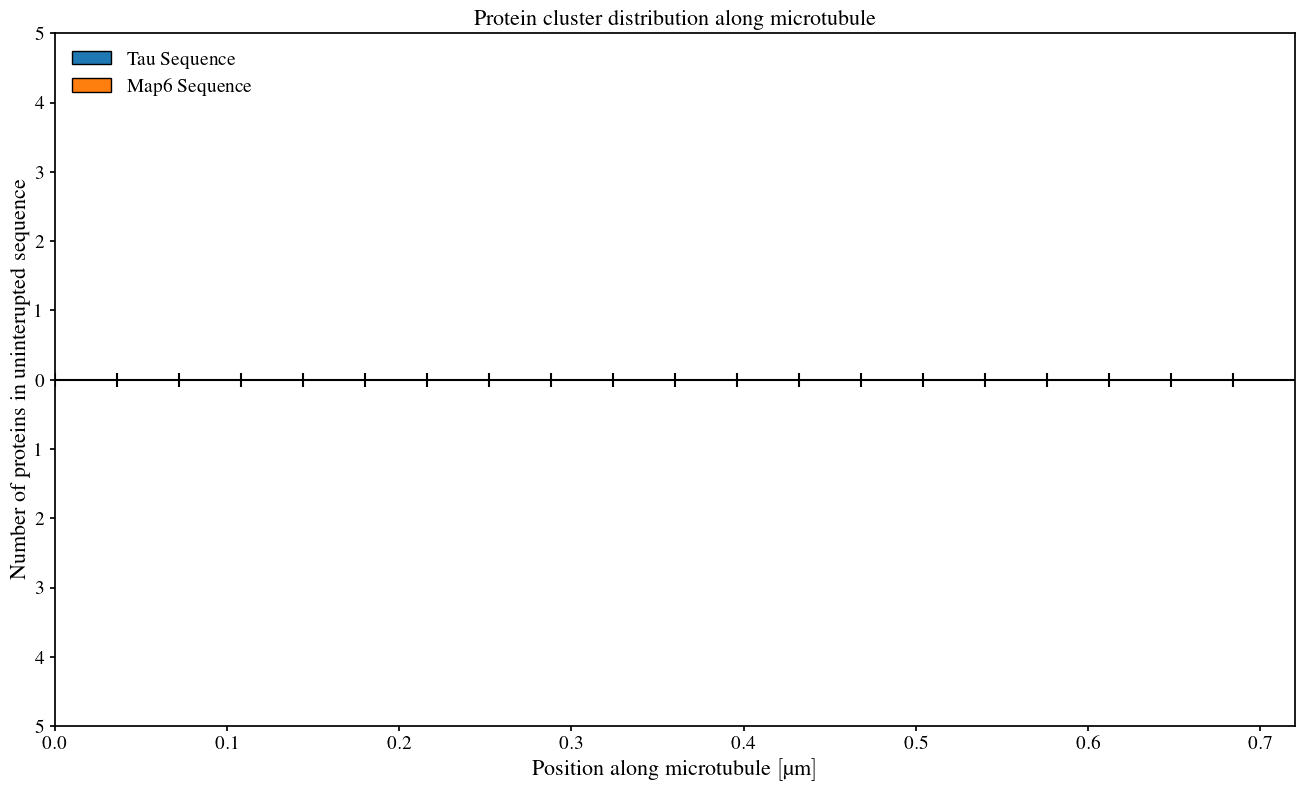

In [15]:
# plot the protein cluster distribution using the function
# define the figure
fig, ax = plt.subplots(figsize=(16, 9))

plot_clusters(fig, ax, sim_name, data_dict, 10, binding_ticks=True)

# save the figure
fig.savefig(FIGURE_DIR / f"{sim_name}_protein_cluster_distribution")

## Animate Clusters

In [16]:
print_options()

Available simulations:
 0 taumap6_10_true
 1 taumap6_1_true
 2 taumap6_5_true
 3 taumap6_50_true

In [17]:
# define the name of the sim to plot
sim_name = list(data_dict["sims"].keys())[0]
print(f"Plotting '{sim_name}' / {list(data_dict['sims'].keys())}.")

Plotting 'taumap6_10_true' / ['taumap6_10_true', 'taumap6_1_true', 'taumap6_5_true', 'taumap6_50_true'].

In [18]:
# # define the desired runtime in seconds
anim_time = 10
frame_rate = 1

# # generate animations for different parameters
create_protein_animation(
    save_path=ANIMATION_DIR / f"{sim_name}_animation_proteins.mp4",
    sim_name=sim_name,
    sim_dict=data_dict,
    frame_rate=frame_rate,
    anim_time=anim_time,
    overwrite=True,
    protein_points_size=30,
    binding_ticks=True)

Animating 'taumap6_10_true' / ['taumap6_10_true', 'taumap6_1_true', 'taumap6_5_true', 'taumap6_50_true'].

Generating Animation: 'taumap6_10_true_animation_proteins.mp4': 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


In [19]:
# generate animations of all simulations
# configure animation properties
frame_rate = 30
anim_time = 10
full_frame_rate = 50

# generate animations
for sim_name in data_dict.keys():
    # make a low res animation
    create_protein_animation(
        save_path=ANIMATION_DIR / f"{sim_name}_animation_proteins.mp4",
        sim_name=sim_name,
        sim_dict=data_dict,
        frame_rate=frame_rate,
        anim_time=anim_time,
        overwrite=True,
        protein_points_size=30,
        binding_ticks=True)

    # make a full res animation that shows each time step
    # run this animation at 50 fps
    # get the number of time steps
    time_steps = data_dict["df"].loc[sim_name]["steps"]
    full_anim_time = int(time_steps / full_frame_rate)
    create_protein_animation(
        save_path=ANIMATION_DIR / f"{sim_name}_animation_proteins_full.mp4",
        sim_name=sim_name,
        sim_dict=data_dict,
        frame_rate=full_frame_rate,
        anim_time=full_anim_time,
        overwrite=True,
        protein_points_size=30,
        binding_ticks=True)